In [1]:
# good model, saved and done.

In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
#from tensorflow.keras.utils import to_categorical ## specific  one I wanna use
from tensorflow.keras import utils
#from tensorflow.keras.layers import Input, Dense, Dropout  # Specific ones I wanna use, can just import whole module
from tensorflow.keras import layers 
from tensorflow.keras.layers import Masking, LSTM, BatchNormalization, Dropout
from tensorflow.keras.models import Model
import h5py
#import tables
import matplotlib.pyplot as plt
#import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight


In [2]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

True

In [11]:
x=1
y=3
x+y

4

In [5]:
# Load padded data
with h5py.File('padded_arr_3d.h5', 'r') as f:
    padded_arr_3d = f['array'][:]

with h5py.File('4_event_types_labels-Copy1.h5', 'r') as f:
    df_labels = f['array'][:]
    
with h5py.File('4_event_types_weights-Copy1.h5', 'r') as f:
    df_weights = f['array'][:]


In [6]:
# Need to take the n leading order jets for my second method
df_labels.shape

(881096,)

In [7]:
X = padded_arr_3d
y = df_labels

print(X.shape)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=10)

input_shape = X_train.shape[2]
print('There are', input_shape, 'variables in this model')
print('The dataset has', len(y), 'processes')


print(X_train.shape)
print(y_train.shape)

(881096, 16, 23)
There are 23 variables in this model
The dataset has 881096 processes
(704876, 16, 23)
(704876,)


In [8]:
#Define the Model

# model = keras.Sequential([
#     layers.BatchNormalization(input_shape=input_shape), 
#     layers.Dense(units=256, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(rate = 0.3), 
#     layers.Dense(units=256, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(rate = 0.3),
#     layers.Dense(units=1, activation='sigmoid'),
# ])


# model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',
#     metrics=['binary_accuracy'],
# )



In [ ]:
# Gridsearchable version

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Masking

from tensorflow.keras.optimizers import Adam

input_shape = (16, X_train.shape[2]) # shape of input sequence#

def create_rnn(num_hidden_layers=2, units=32, dropout_rate=0.2, optimizer='adam', learning_rate=0.001, activation='relu', input_shape=(16, X_train.shape[2])):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=input_shape))
    model.add(LSTM(units=units, return_sequences=True,))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))              
    for i in range(num_hidden_layers-1):
        model.add(LSTM(units=units, return_sequences=True))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        
    model.add(LSTM(units=units))
    model.add(Dense(1, activation='sigmoid'))
              
              
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

    return model

rnn = KerasClassifier(build_fn=create_rnn, epochs=25, batch_size=128)


param_grid = {
    'batch_size': [264,512],
    'dropout_rate': [0.2],
    'optimizer': ['adam'],
    'learning_rate': [0.001],
    'activation': ['relu'],
    'num_hidden_layers': [0 ,1, 2],
    'units': [32, 64]
}

class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
print(class_weights)
class_weight = {0: class_weights[0], 
               1: class_weights[1]}        # Done by compute_class_weight('balanced', np.unique(y_train), y_train) in cell above



early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    min_delta=0.001,
    restore_best_weights=True
)



from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score

#Define the scoring functions
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score)
}


# Create the GridSearchCV object
grid = GridSearchCV(
    estimator=rnn,
    param_grid=param_grid,
    scoring=scoring,
    refit='roc_auc',
    cv=3,
    verbose=2
    
)

# Fit the model and get the results

grid_result = grid.fit(X_train, y_train, validation_data=(X_valid, y_valid), class_weight=class_weight, callbacks=[early_stopping])


#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


[0.62673917 2.47255507]
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] activation=relu, batch_size=264, dropout_rate=0.2, learning_rate=0.001, num_hidden_layers=0, optimizer=adam, units=32 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 469917 samples, validate on 176220 samples
Epoch 1/25
469917/469917 [==============================] - 117s 248us/sample - loss: 0.6165 - accuracy: 0.6198 - val_loss: 0.6089 - val_accuracy: 0.5904
Epoch 2/25
469392/469917 [============================>.] - ETA: 0s - loss: 0.6101 - accuracy: 0.6321

In [12]:
# Print the best results
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best ROC AUC score: {grid_result.best_score_}")
print(f"Best accuracy score: {grid_result.cv_results_['mean_test_accuracy'][grid_result.best_index_]}")

      

Best parameters: {'activation': 'relu', 'batch_size': 512, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 0, 'optimizer': 'adam', 'units': 64}
Best ROC AUC score: 0.6767397211671978
Best accuracy score: 0.6703632885150488


In [14]:
grid.cv_results_

{'mean_fit_time': array([2708.43504675, 2519.69834065, 2165.66379754, 2228.0286053 ,
        3043.48634489, 3036.33517059, 1116.94454765, 1081.76714484,
        1102.45558651, 1088.14349707, 1581.48970477,   33.86854132]),
 'std_fit_time': array([108.12842076, 275.96880891,  31.28594916, 104.07244432,
         45.20940426,  43.36777947,  33.52784121,   6.303379  ,
         10.92276108,  17.77891133,  28.76647634,   5.09377143]),
 'mean_score_time': array([27.00441448, 21.08275334, 18.33754492, 20.00976547, 29.26641623,
        24.48329949, 10.57069031, 10.46521966, 13.69957352, 10.4452726 ,
        15.40499099,  0.        ]),
 'std_score_time': array([4.37376987, 2.28319477, 0.15965515, 2.41375931, 0.21552258,
        0.79730711, 0.34559759, 0.45964427, 4.23371503, 0.04743698,
        0.13051528, 0.        ]),
 'param_activation': masked_array(data=['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu',
                    'relu', 'relu', 'relu', 'relu', 'relu'],
              mask=[F

In [15]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_roc_auc']
stds = grid.cv_results_['std_test_roc_auc']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.676740 using {'activation': 'relu', 'batch_size': 512, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 0, 'optimizer': 'adam', 'units': 64}
0.672511 (0.000386) with: {'activation': 'relu', 'batch_size': 264, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 0, 'optimizer': 'adam', 'units': 32}
0.675839 (0.000734) with: {'activation': 'relu', 'batch_size': 264, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 0, 'optimizer': 'adam', 'units': 64}
0.673827 (0.001613) with: {'activation': 'relu', 'batch_size': 264, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 1, 'optimizer': 'adam', 'units': 32}
0.675482 (0.001268) with: {'activation': 'relu', 'batch_size': 264, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 1, 'optimizer': 'adam', 'units': 64}
0.672421 (0.000789) with: {'activation': 'relu', 'batch_size': 264, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 

Train on 704876 samples, validate on 176220 samples
Epoch 1/15
704876/704876 [==============================] - 80s 114us/sample - loss: 0.6168 - accuracy: 0.6205 - val_loss: 0.6086 - val_accuracy: 0.6613
Epoch 2/15
704876/704876 [==============================] - 56s 79us/sample - loss: 0.6101 - accuracy: 0.6347 - val_loss: 0.6063 - val_accuracy: 0.5998
Epoch 3/15
704876/704876 [==============================] - 55s 79us/sample - loss: 0.6072 - accuracy: 0.6426 - val_loss: 0.6017 - val_accuracy: 0.6444
Epoch 4/15
704876/704876 [==============================] - 57s 81us/sample - loss: 0.6054 - accuracy: 0.6479 - val_loss: 0.5997 - val_accuracy: 0.6610
Epoch 5/15
704876/704876 [==============================] - 58s 82us/sample - loss: 0.6041 - accuracy: 0.6501 - val_loss: 0.5996 - val_accuracy: 0.6729
Epoch 6/15
704876/704876 [==============================] - 56s 80us/sample - loss: 0.6028 - accuracy: 0.6532 - val_loss: 0.5984 - val_accuracy: 0.6447
Epoch 7/15
704876/704876 [=========

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation accuracy: 0.6604472


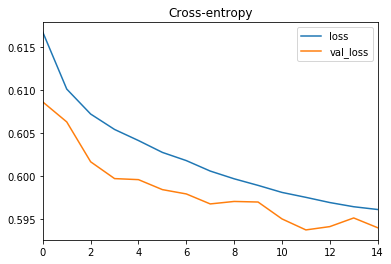

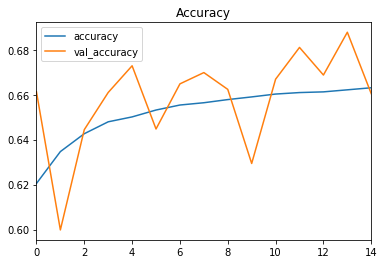

In [16]:
# Evaluate the performance of the best model
best_params = grid.best_params_
best_model = create_rnn(
    num_hidden_layers=best_params['num_hidden_layers'],
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    optimizer=best_params['optimizer'],
    activation=best_params['activation']
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    min_delta=0.001,
    restore_best_weights=True
)
history = best_model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=best_params['batch_size'],
    epochs=15,
    callbacks=[early_stopping],
    class_weight=class_weight
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

# Generate some accuracy metrics
score = best_model.evaluate(X_valid, y_valid)
print('Validation accuracy:', score[1])


In [17]:
# want to see what other variables in df

print(history_df)



        loss  accuracy  val_loss  val_accuracy
0   0.616775  0.620491  0.608639      0.661270
1   0.610145  0.634676  0.606315      0.599824
2   0.607232  0.642632  0.601660      0.644433
3   0.605433  0.647934  0.599700      0.660975
4   0.604139  0.650114  0.599579      0.672863
5   0.602756  0.653174  0.598414      0.644740
6   0.601800  0.655402  0.597910      0.664817
7   0.600580  0.656418  0.596745      0.669839
8   0.599677  0.657822  0.597034      0.662360
9   0.598909  0.659011  0.596968      0.629389
10  0.598088  0.660282  0.594998      0.666894
11  0.597513  0.660945  0.593713      0.681029
12  0.596906  0.661254  0.594099      0.668744
13  0.596417  0.662165  0.595109      0.687788
14  0.596095  0.663081  0.593971      0.660447


Best Validation Loss: 0.5937
Best Validation Accuracy: 0.6878


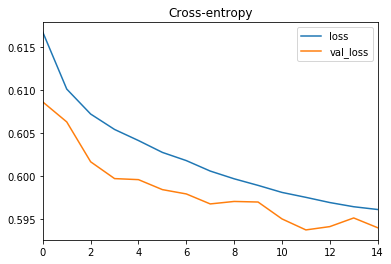

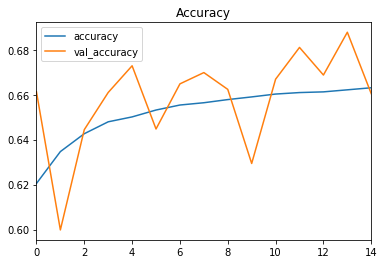

In [18]:
# print training curves

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

In [ ]:
#model.save('trained_model_16pad_128_50epoch_4Layers_seed10.h5')

In [21]:
# Generate some accuracy metrics
score = best_model.evaluate(X_valid, y_valid)
print('Validation accuracy:', score[1])



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation accuracy: 0.6604472


In [41]:
best_model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_37 (Masking)         (None, 16, 23)            0         
_________________________________________________________________
lstm_86 (LSTM)               (None, 16, 32)            7168      
_________________________________________________________________
batch_normalization_49 (Batc (None, 16, 32)            128       
_________________________________________________________________
dropout_49 (Dropout)         (None, 16, 32)            0         
_________________________________________________________________
lstm_87 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 33        
Total params: 15,649
Trainable params: 15,585
Non-trainable params: 64
________________________________________________

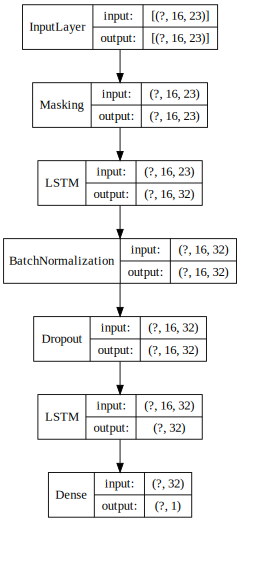

In [42]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(best_model, show_shapes=True, show_layer_names=False, dpi=65).create(prog='dot', format='svg'))


In [ ]:

#from tensorflow.keras.models import load_model
#model = load_model('trained_model_16pad_128_50epoch_4Layers_seed10.h5')

In [ ]:
#model.save('trained_model_16pad RNN3_128_seed10.h5')


#from tensorflow.keras.models import load_model
#model = load_model('trained_model_RNN3_seed10.h5')


In [ ]:
# Found model.evaluate took 383s
# Found model.predict took 
# Should have used timit really

True
704876/1 - 320s - loss: 0.5655 - accuracy: 0.6626
Validation loss: 0.5894861748138724
Validation accuracy: 0.66262716
704876/1 - 318s


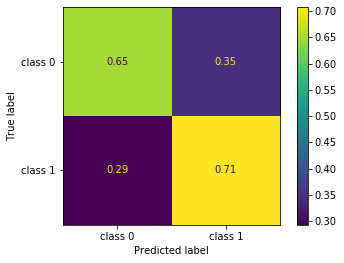

Total signal processes; 1.0
Total background processes; 1.0
296892
There is 142540 signal in the set
The model predicted 154352 more ones than in reality
407984
There is 562336 background in the set
The model predicted -154352 more ones than in reality


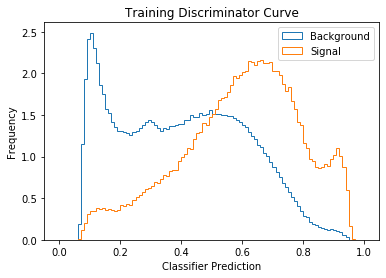

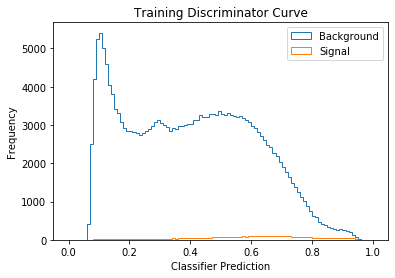

In [22]:
# evaluate the model on the training data, confusion matrix and discriminator curve

model = best_model

gpu_available = tf.test.is_gpu_available()
print(gpu_available)   # check still on the gpu

val_loss, val_acc = model.evaluate(X_train, y_train, verbose = 2)    

print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred = model.predict(X_train, verbose = 2)
y_pred_round = np.round(y_pred)
#print(y_pred)

# compute the confusion matrix

cm = confusion_matrix(y_train, y_pred_round, normalize = 'true')   #, normalize = 'true')  #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env

disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

# Check if order of y_valid is the same order as y_pred
# expect to be the ssame order if accuracy is same as validation accuracy above.

# list of true outcomes
y_train_list = list(y_train)

# list of rounded predictions 
y_pred_round_list = list(y_pred_round)

data_test = {'True_Val': y_train_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
df_test = pd.DataFrame(data_test)

# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df_test = df_test.sort_values(by='True_Val')
df_test

# Convert arrays to scalars
df_test['Round Prediction'] = df_test['Round Prediction'].apply(lambda x: x[0])
        
pred_one = df_test['Round Prediction'].value_counts()[1.0]
ones_in_set = df_test['True_Val'].value_counts()[1]

# Print the result
print(pred_one)
print('There is', ones_in_set, 'signal in the set')
print('The model predicted',pred_one-ones_in_set ,'more ones than in reality')


pred_zeros = df_test['Round Prediction'].value_counts()[0.0]
zeros_in_set = df_test['True_Val'].value_counts()[0]

# Print the result
print(pred_zeros)
print('There is', zeros_in_set, 'background in the set')   #agrees w/ confusion matrix
print('The model predicted', pred_zeros-zeros_in_set,'more ones than in reality')


#Split df into signal and bg

df_bg = df_test[df_test['True_Val'] == 0]
df_signal = df_test[df_test['True_Val'] == 1]

# Make discriminator curves, Histogram

# manipluate data so can be used for Histograms
lst_bg_predicted = []
for i in df_bg['Predicted']:
    lst_bg_predicted.append(i)

lst_of_values_bg_pred_train = [arr.item() for arr in lst_bg_predicted]

lst_signal_predicted = []
for i in df_signal['Predicted']:
    lst_signal_predicted.append(i)

lst_of_values_signal_pred_train = [arr.item() for arr in lst_signal_predicted]

binwidth = 0.01
bins=np.arange(0, 1 + binwidth, binwidth)
    

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('Training Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised

plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5*1/0.8,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5*1/0.8,
         histtype = 'step', label = 'Signal')
plt.title('Training Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
#plt.xlim(0.9,1)    #zoom in on 0.9 to 1 region
#plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()


#start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

In [23]:
a = df_weights[:len(lst_of_values_bg_pred_train),1]
print(a)
df_weights

[1.0588149e-06 1.0588149e-06 1.0588149e-06 ... 1.0588149e-06 1.0588149e-06
 1.0588149e-06]


array([[3.9628825e-09, 1.0588149e-06, 1.1520365e-06, 8.6958615e-08],
       [3.9628825e-09, 1.0588149e-06, 1.1520365e-06, 8.6958615e-08],
       [3.9628825e-09, 1.0588149e-06, 1.1520365e-06, 8.6958615e-08],
       ...,
       [          nan, 1.0482267e-06,           nan,           nan],
       [          nan, 1.0588149e-06,           nan,           nan],
       [          nan, 1.0588149e-06,           nan,           nan]],
      dtype=float32)

True
176220/1 - 81s - loss: 0.6445 - accuracy: 0.6604
Validation loss: 0.5913898196492072
Validation accuracy: 0.6604472
176220/1 - 79s


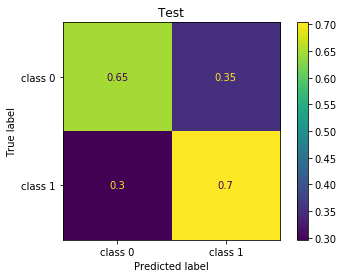

Total signal processes; 1.0
Total background processes; 1.0


In [24]:
# evaluate the model on the validation data

gpu_available = tf.test.is_gpu_available()
print(gpu_available)   # check still on the gpu

val_loss, val_acc = model.evaluate(X_valid, y_valid, verbose = 2)   
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred = model.predict(X_valid, verbose = 2)
y_pred_round = np.round(y_pred)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_round, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp.plot()
plt.title('Test')
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

In [ ]:
# #using a permutation method to see what features are important

# # Get the number of features
# n_features = X_valid.shape[1]

# # Initialize an array to store feature importances
# importances = np.zeros(n_features)

# # Calculate the feature importances using the permutation feature importance method
# # Drops each variable one at a time 
# for i in range(n_features):
#     print(i)    #counter to check is working, should go to 40
#     feature_name = X_valid.columns[i]
#     X_permuted = X_valid.copy().values
#     X_permuted[:, i] = np.random.permutation(X_permuted[:, i])
#     y_permuted = model.predict(X_permuted)
#     importances[i] = np.abs(y_permuted - y_pred).mean()
#     #importances[i] = (y_permuted - y_pred).mean()    #try without a abs, see if positively or negatively affected by removal?
#     print(f"Permuted feature {feature_name}")

# # Normalize the feature importances
# importances /= importances.sum()   # importances sum to 1, so can be taken as a literal how important a variable
# # is for the model

# print(importances)  # using abs

# print()#

# print(np.sort(importances))

# # np.random.permutation randomly permutes (rearranges in a random order) the elements.
# # In this case, it is used to shuffle the values in a single column of the X_permuted array.
# # Guess then this variable isnt useful in the prediction

In [ ]:
# importances_dict = dict(zip(importances, X_valid.columns))
# # key:value

# #print(combined_dict)

# # get values for keys less than 0.01
# values = []
# for key, value in importances_dict.items():
#     if key < 0.01:
#         values.append(value)

# # print the values
# print(values)


In [ ]:
# get indices of numbers less than 0.01
# for i in range(len(importances)):
#     if importances[i] < 0.05:
#         print(X_valid.columns[i])

In [25]:
# Check if order of y_valid is the same order as y_pred
# expect to be the ssame order if accuracy is same as validation accuracy above.

# list of true outcomes
y_valid_list = list(y_valid)

# list of rounded predictions 
y_pred_round_list = list(y_pred_round)

# list of whether these are same    
z=[]
for i in range(len(y_valid_list)):
    if y_valid_list[i]==y_pred_round_list[i]:
        z.append(1)
    else:
        z.append(0)
        
print(sum(z)/len(z))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(z)/len(z) < val_acc + tol)

# If true, suggests are in same order 

0.6604471683123369
True


In [26]:
print(min(y_pred))
max(y_pred)

[0.05915579]


array([0.9668399], dtype=float32)

In [27]:
data = {'True_Val': y_valid_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
df = pd.DataFrame(data)

# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df = df.sort_values(by='True_Val')
df

# Convert arrays to scalars
df['Round Prediction'] = df['Round Prediction'].apply(lambda x: x[0])

df

,True_Val,Predicted,Round Prediction
88109,0,[0.22168234],0.0
111032,0,[0.5209366],1.0
111033,0,[0.15936762],0.0
111034,0,[0.07576996],0.0
111035,0,[0.13766342],0.0
...,...,...,...
27764,1,[0.79539657],1.0
141597,1,[0.55753255],1.0
27763,1,[0.74232763],1.0
100490,1,[0.61632377],1.0


In [28]:
df

,True_Val,Predicted,Round Prediction
88109,0,[0.22168234],0.0
111032,0,[0.5209366],1.0
111033,0,[0.15936762],0.0
111034,0,[0.07576996],0.0
111035,0,[0.13766342],0.0
...,...,...,...
27764,1,[0.79539657],1.0
141597,1,[0.55753255],1.0
27763,1,[0.74232763],1.0
100490,1,[0.61632377],1.0


In [29]:
# Check that they maintained order in the df:

lst=[]
for i in range(len(df)):
    if df['True_Val'][i] == df['Round Prediction'][i]:
        lst.append(1)
    else:
        (lst.append(0))
print(sum(lst)/len(lst))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(lst)/len(lst) < val_acc + tol)

# If true, suggests are in same order 

0.6604471683123369
True


In [30]:
pred_one = df['Round Prediction'].value_counts()[1.0]
ones_in_set = df['True_Val'].value_counts()[1]

# Print the result
print(pred_one)
print('There is', ones_in_set, 'signal in the set')
print('The model predicted',pred_one-ones_in_set ,'more ones than in reality')


pred_zeros = df['Round Prediction'].value_counts()[0.0]
zeros_in_set = df['True_Val'].value_counts()[0]

# Print the result
print(pred_zeros)
print('There is', zeros_in_set, 'background in the set')   #agrees w/ confusion matrix
print('The model predicted', pred_zeros-zeros_in_set,'more ones than in reality')


74236
There is 35318 signal in the set
The model predicted 38918 more ones than in reality
101984
There is 140902 background in the set
The model predicted -38918 more ones than in reality


now first half of df is background, other half is signal

PROBLEM, TEST AND VALID WAS SPLIT RANDOMLY, SO NOT ACTUALLY SAME AMOUNT OF 0's AND 1's

Not a problem, but need to check if should be like this

 A couple of options, I could:

Deal with it, and let there be uneven amounts of 1's and 0's

OR

Go back to test_train_split, and apply individually to signal and background and then sum them?

This would guarantee 50/50


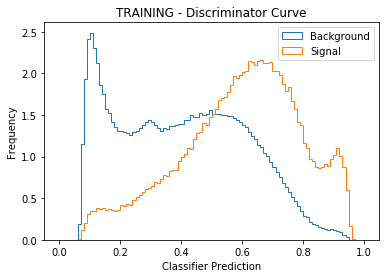

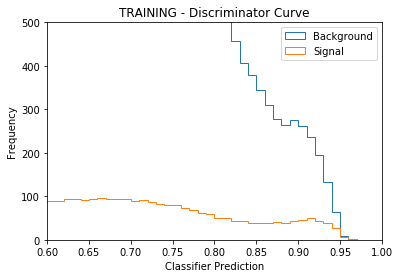

In [32]:
# Training Discriminator curves

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('TRAINING - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised


plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5*1/0.8,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5*1/0.8,
         histtype = 'step', label = 'Signal')
plt.title('TRAINING - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.6,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,500)    # need to zoom in
plt.legend()
plt.show()


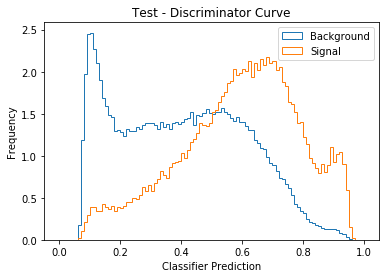

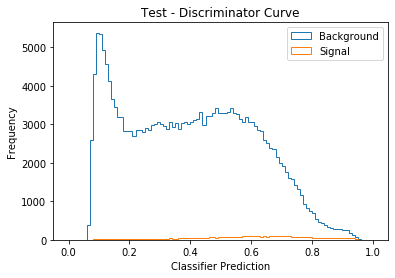

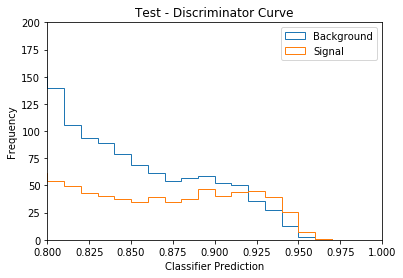

In [33]:
#Split df into signal and bg

df_bg = df[df['True_Val'] == 0]
df_signal = df[df['True_Val'] == 1]

# Make Validation discriminator curves, Histogram

# manipluate data so can be used for Histograms
lst_bg_predicted = []
for i in df_bg['Predicted']:
    lst_bg_predicted.append(i)

lst_of_values_bg_pred = [arr.item() for arr in lst_bg_predicted]

lst_signal_predicted = []
for i in df_signal['Predicted']:
    lst_signal_predicted.append(i)

lst_of_values_signal_pred = [arr.item() for arr in lst_signal_predicted]

binwidth = 0.01
bins=np.arange(0, 1 + binwidth, binwidth)

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('Test - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5*1/0.2,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5*1/0.2,
         histtype = 'step', label = 'Signal')
plt.title('Test - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
#plt.xlim(0.9,1)    #zoom in on 0.9 to 1 region
#plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()
    
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5*1/0.2,
         histtype = 'step', label = 'Signal')
plt.title('Test - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.8,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()


#start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

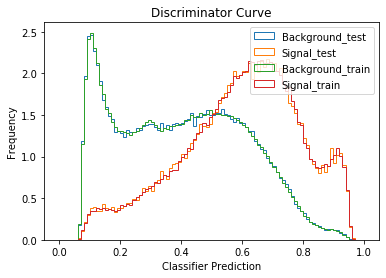

In [34]:
# Test and Training overlayed

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background_test')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal_test')
plt.title('Test - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()


#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background_train')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal_train')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

num_bg_events =  217678.7810239792
num_signal_events =  4367.311522901058


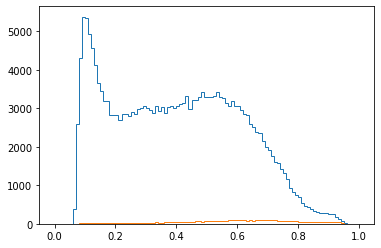

In [35]:
#Calculate number of events

n_bg, bins_bg, patches_bg = plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5*1/0.2,
         histtype = 'step', label = 'Background')
n_signal, bins_signal, patches_signal = plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5*1/0.2,
         histtype = 'step', label = 'Signal')

# calculate the number of events
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print('num_bg_events = ', num_bg_events)
print('num_signal_events = ', num_signal_events)

In [ ]:
#plot ROC curves

y_true = df['True_Val']
y_score = df['Predicted']

# calculate the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(roc_auc)  

print(len(thresholds))



In [ ]:
data_roc = {'thresholds': thresholds, 'tpr': tpr, 'fpr': fpr, 'tpr/sqrt(fpr)':tpr/np.sqrt(fpr)}
df_roc = pd.DataFrame(data_roc)
#df_roc
df_roc.head(20)
plt.plot(df_roc['thresholds'][3:], df_roc['tpr/sqrt(fpr)'][3:])
plt.show()
max(df_roc['tpr/sqrt(fpr)'][3:])

In [ ]:
# Plot precision recall curve
from sklearn.metrics import average_precision_score

y_true = df['True_Val']
y_score = df['Predicted']

# calculate the precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_score)

# plot the precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show()

AUC = average_precision_score(y_true, y_score)   
print(AUC)

In [ ]:
df['True_Val']
x = df['Predicted']
print(x)

# Significance

$$ Z = \frac{s}{\sqrt(B+\sigma_s^{2})}  $$

s = number of signal

B = number of background

$\sigma_s$ = statistical uncertainty (~10% of B)

217678.7810239792
4367.311522901058


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


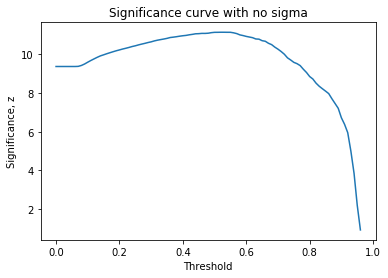

0.52
52
11.126887245048776

If cut at a threshold of 0.52 have
2936.4041748046875 singal events
69644.09375 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less


In [36]:
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    num_bg_events = np.sum(n_bg[i:])
    num_signal_events = np.sum(n_signal[i:])
    #print(num_signal_events)
    z_i = num_signal_events / np.sqrt(num_bg_events)
    z[i] = z_i
#print(z)


x = np.linspace(0,1,len(z))
plt.plot(bins_bg,z[:])
#plt.xlim([0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with no sigma')
plt.show()


mask = z < 1e10     #just so doesnt include infs
index_of_max = np.argmax(z[mask])
max_value = np.amax(z[mask])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin = bins_bg[index_of_max]
print(max_bin)
print(index_of_max)
print(max_value)


num_bg_threshold = np.sum(n_bg[index_of_max:])
num_signal_threshold = np.sum(n_signal[index_of_max:])


print()
print('If cut at a threshold of', index_of_max/100, 'have')
print(num_signal_threshold, 'singal events')
print(num_bg_threshold, 'background events')

# significance = sigmna, 6.5 signma, 5 sigma

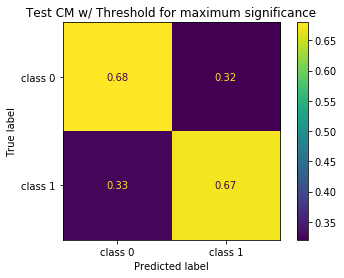

Total signal processes; 1.0
Total background processes; 1.0


In [37]:
# Confusion matricies with new threshold at max significance

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold = max_bin
y_pred_threshold = np.where(y_pred >= significance_threshold, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
disp.plot()
plt.title('Test CM w/ Threshold for maximum significance')
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

217678.7810239792
4367.311522901058


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


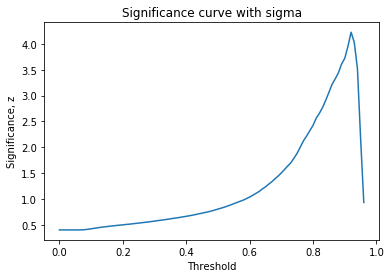

0.92
92
4.224813798871029

If cut at a threshold of 0.92 have
117.98583984375 singal events
393.265625 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


In [38]:
# significance with systematic uncertainty term

num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    num_bg_events = np.sum(n_bg[i:])
    num_signal_events = np.sum(n_signal[i:])
    #print(num_signal_events)
    z_i = num_signal_events / np.sqrt(num_bg_events + (0.05*num_bg_events)**2)
    
    z[i] = z_i
#print(z)


x = np.linspace(0,1,len(z))
plt.plot(bins_bg,z[:])
#plt.xlim([0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with sigma')
plt.show()


mask = z < 1e10     #just so doesnt include infs
index_of_max = np.argmax(z[mask])
max_value = np.amax(z[mask])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin = bins_bg[index_of_max]
print(max_bin)
print(index_of_max)
print(max_value)

num_bg_threshold = np.sum(n_bg[index_of_max:])
num_signal_threshold = np.sum(n_signal[index_of_max:])
print()
print('If cut at a threshold of', index_of_max/100, 'have')
print(num_signal_threshold, 'singal events')
print(num_bg_threshold, 'background events')
# significance = sigmna, 6.5 signma, 5 sigma

217678.7810239792
4367.311522901058


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


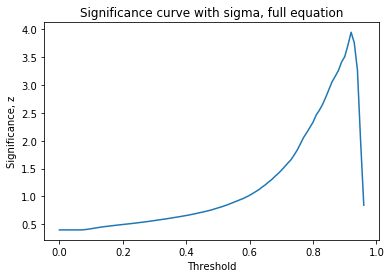

0.92
92
3.9459963018787336

If cut at a threshold of 0.92 have
117.98583984375 singal events
393.265625 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less


In [39]:
# significance with systematic uncertainty term, full equation

num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    b = np.sum(n_bg[i:])
    s = np.sum(n_signal[i:])
    #print(num_signal_events)
    sigma = 0.05*b
    
    part1 = (s+b)*np.log(((s+b)*(b+sigma**2))/(b**2+((s+b)*sigma**2)))
    part2 = (b**2/sigma**2)*np.log(1+((sigma**2*s)/(b*(b+sigma**2))))
    
    z_i = (2*(part1-part2))**(1/2)

    
    z[i] = z_i
#print(z)
#print(z)


x = np.linspace(0,1,len(z))
plt.plot(bins_bg,z[:])
#plt.xlim([0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with sigma, full equation')
plt.show()


mask = z < 1e10     #just so doesnt include infs
index_of_max = np.argmax(z[mask])
max_value = np.amax(z[mask])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin = bins_bg[index_of_max]
print(max_bin)
print(index_of_max)
print(max_value)

num_bg_threshold = np.sum(n_bg[index_of_max:])
num_signal_threshold = np.sum(n_signal[index_of_max:])
print()
print('If cut at a threshold of', index_of_max/100, 'have')
print(num_signal_threshold, 'singal events')
print(num_bg_threshold, 'background events')
# significance = sigmna, 6.5 signma, 5 sigma

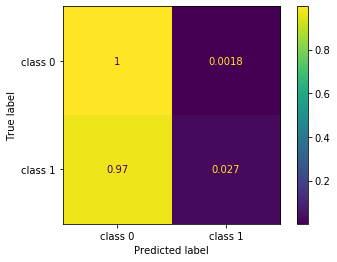

Total signal processes; 1.0
Total background processes; 1.0


In [40]:
# Confusion matricies with new threshold at max significance

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold = max_bin
y_pred_threshold = np.where(y_pred >= significance_threshold, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

# SAVE THE CORRECT DATA

In [43]:
y_pred_valid = model.predict(X_valid, verbose = 2)
y_pred_train = model.predict(X_train, verbose = 2)

with h5py.File('predictions_rnn_grid_bestmodel_.h5', 'w') as f:
    f.create_dataset('val_preds', data=y_pred_valid)
    f.create_dataset('train_preds', data=y_pred_train)

176220/1 - 77s
704876/1 - 308s


In [ ]:
y_pred_train

In [ ]:
y_pred_valid

In [ ]:
# # Make not an object, so can hdf save
# # run last anyways

# df['True_Val'] = df['True_Val'].astype(float)
# df['Predicted'] = df['Predicted'].astype(float)
# df['Round Prediction'] = df['Round Prediction'].astype(float)


In [ ]:

# with h5py.File('data_valid_16pad_128_50epoch_4Layers_SEED10.h5', 'w') as f:
#     f.create_dataset('True_Val', data=df['True_Val'])
#     f.create_dataset('Predicted', data=df['Predicted'])
#     f.create_dataset('Round_Prediction', data=df['Round Prediction'])

    
# #with h5py.File('data_train_16pad_RNN3_SEED10.h5', 'r') as f:
# #   true_val = f['True_Val'][:]
# #   predicted = f['Predicted'][:]
# #   round_pred = f['Round_Prediction'][:]
    


# #my_dict = {'True_Val': true_val.flatten(), 'Predicted': predicted.flatten(), 'Round Prediction': round_pred.flatten()}
# #df = pd.DataFrame(my_dict)

In [ ]:
# df_test['True_Val'] = df_test['True_Val'].astype(float)
# df_test['Predicted'] = df_test['Predicted'].astype(float)
# df_test['Round Prediction'] = df_test['Round Prediction'].astype(float)

# with h5py.File('data_train_16pad_128_50epoch_4Layers_SEED10.h5', 'w') as f:
#     f.create_dataset('True_Val', data=df_test['True_Val'])
#     f.create_dataset('Predicted', data=df_test['Predicted'])
#     f.create_dataset('Round_Prediction', data=df_test['Round Prediction'])

In [ ]:
# See weight is const basically, so just use a value

semi_xs_weight = df2['xs_weight']   # plot to show is wrong, at least 1 -ive val (is this right?)
signal_xs_weight = df4['xs_weight'] 
#plt.hist(x=semi_xs_weight, bins = 10, weights = df2.xs_weight, density = True, histtype = 'step', label = 'Background')
plt.hist(x=signal_xs_weight, bins = 10, weights = df4.xs_weight, density = True, histtype = 'step', label = 'Signal')
plt.title('xs_weight')
plt.legend()
plt.show() 

semi_xs_weight = df2['xs_weight']   # plot to show is wrong, at least 1 -ive val (is this right?)
signal_xs_weight = df4['xs_weight'] 
plt.hist(x=semi_xs_weight, bins = 10, weights = df2.xs_weight, density = True, histtype = 'step', label = 'Background')
#plt.hist(x=signal_xs_weight, bins = 10, weights = df4.xs_weight, density = True, histtype = 'step', label = 'Signal')
plt.title('xs_weight')
plt.legend()
plt.show() 

In [ ]:
#Also, to make sure we get the event weights correct, can each of you try and produce a number for the 
#total number of events you obtain when using all events in the ttH125 and ttbar semileptonic dataframes,
#normalized to 300/fb?
#Hopefully you all arrive at the same result.

# Sligthly confused, does x_s weight normalised already entail no. events,
# So xs_weight * 300,000 is no events

#Or

# Are we meant to use the equation you showed us last week and work out what N should be

#Or

# do both and compare them as should be same?

bg_weight = semi_xs_weight[1]
signal_weight = signal_xs_weight[1]

# total number SL
sl_tot_events = bg_weight * 300000      # weight per pb to 300fb

# total number signal
signal_tot_events = signal_weight * 300000

print('Total number of semileptonic events is {}'.format(sl_tot_events))
print('Total number of ttH125 events is {}'.format(signal_tot_events))
print()

sl_events = 300000 * 500
signal_events = 300000 * 0.5

print('Total number of semileptonic events is {}'.format(sl_events)) #150000k
print('Total number of ttH125 events is {}'.format(signal_events))   #150k
#tot_events = 

# Q 
Can you also overlay the discriminator distributions for the test data 
(normalized to the same area) to check if training and testing samples agree?
# A
not sure what is meant, so show code for the one that I did do. I did it for validation data, so when he says this does hr mean my data is test or training

# Q 
If you use all the events in the dataframes and weight each entry by xs_weight you should
get the expected number of events for 1 /pb. Is everything in the plot below already 
multiplied by 300000 to get the event yields expected for 300/fb?
What exactly did you use?

# A
Yes, everything in the weighted plot is multiplied by 300000, show what I used as I am not sure if thats right

# Q
If you integrate the weighted histograms, how many events do you obtain in each histogram? 

# A
Bit confused, why integrate the histograms when can just see how much data used, is it because this is weighted so it will give the number of events we actually expect overall in 300000 fb^-1, makes sense.
#Did 3 ways, not really clear what was right, way I think rn is each bin is a number of events, so just need to add number events per bin, dont need to do anything regarding the width of the bin? But then an integral is the area so that does mean bin size matters, but not really sure, bc obvs sum bin size = 1
#Think first one is correct


# Q 
Next would be to plot ROC curves and precision-recall which have slightly different meaning.

# A
So does a ROC curve work out where the best threshold is for us, so what is significance. Also should a ROC curve be weighted

# Q 
from the weighted plot, make a plot of Z = S/sqrt(B) as a function of the cut on the discriminator value, where S and B are the number of events (i.e. the integral) of the histogram 
that have discriminator value above the cut you chose. You may need to “zoom in” on the region >0.9 
to see that it falls off again as you approach 1

In [ ]:
print(df1['xs_weight'])
plt.hist(df1['xs_weight'])

In [ ]:
print(df2['xs_weight'])
plt.hist(df2['xs_weight'])

In [ ]:
print(df3['xs_weight'])
plt.hist(df3['xs_weight'])

In [ ]:
print(df4['xs_weight'])
plt.hist(df4['xs_weight'])

In [ ]:
print('TTToHadronic weight: ', df1['xs_weight'][10000])
print('TTToSL weight: ', df2['xs_weight'][0])
print('TTL2NU weight: ', df3['xs_weight'][0])
print('TTH125 weight: ', df4['xs_weight'][0])

# Updates from 08/02 grind
- I trained on full dataset and got like 10% more accuracy, actually a v good now, loss also down a fair bit, 0.1

- But does take like 10 mins to run training data

- Actually, not that good


In [ ]:
y_pred = model.predict(X_valid, verbose = 2)

In [ ]:
y_pred

In [ ]:
df['Predicted']

In [ ]:
data = {'True_Val': y_valid_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
df = pd.DataFrame(data)
df


In [ ]:
# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df = df.sort_values(by='True_Val')

# Convert arrays to scalars
#df['Round Prediction'] = df['Round Prediction'].apply(lambda x: x[0])

df